In [3]:
import panda
import numpy as np
import os
import os.path as osp
import matplotlib.pyplot as plt

---

In [4]:
# Set up paths and configuration

# Replace to your path
folder = os.environ['HOME'] + '/PANDA_exp/panda_nn/calcite_decane_water_roll' # Folder containing the trajectory and topology files
trajectory_file = osp.join(folder, 'cal_dec_tip4p.xtc') # Path to the trajectory file (XTC format)
topology_file = osp.join(folder, 'cal_dec_tip4p.gro') # Path to the topology file (GRO format)
residue = 'DECAN' # Name of the residue for which the density profile is calculated
H = 6.0 # Height of the system in nanometers
l = 11.6235 / H # Length scale for normalization
phi = 0.5 # Volume fraction of the phase
rho_bulk = 3.0896 * 10 # Bulk density of the residue (1 / nm^3)
interface_type = 'roll' # Type of interface (geometry of the interface, e.g., 'roll', 'worm', etc.)
sl = 200 # Number of bins for the density profile (spatial resolution)
units = 'ps' # Time units used in the trajectory ('ps' for picoseconds, 'ns' for nanoseconds)
timestep = 2 # Time step of the simulation in picoseconds (ps)
chunk_length = 1000 # Number of frames to load from trajectory (chunk size)
begin_time = 0 # Time (in ps) to start analysis from (usually 0)
time = 20000000 * timestep // 1000 # Total simulation time in ps (nsteps * timestep / 1000)

block_length = 1000 # Number of frames per block for averaging

In [5]:
# Calculate density profiles for each chunk of the trajectory
axises, denses = panda.get_density_profile(
    trajectory_file,
    topology_file,
    residue,
    sl,
    chunk_length,
    begin_time,
    time,
    timestep,
    units
)

# Save for later use (optional)
np.save('axises', axises)
np.save('denses', denses)

Chunk: 100%|██████████| 40/40 [03:26<00:00,  5.17s/it]


In [6]:
# Block average using PANDA's function
axises_avg, denses_avg = panda.block_average_density_profile(axises, denses, block_length)
print('Averaged axises shape:', axises_avg.shape)
print('Averaged denses shape:', denses_avg.shape)

Averaged axises shape: (20, 200)
Averaged denses shape: (20, 200)


In [7]:
angles_deg = []
for i in range(len(denses_avg)):
    axis_i, dens_i, result = panda.profile_approx_from_array(
        denses_avg[i, :],
        axises_avg[i, :],
        rho_bulk,
        l,
        phi,
        H,
        interface_type=interface_type,
        display=False
    )
    angle_deg = np.rad2deg(result['theta'])
    angles_deg.append(angle_deg)
    print(f'Block {i}: Contact angle = {angle_deg:.2f} degrees')

Block 0: Contact angle = 102.25 degrees
Block 1: Contact angle = 110.88 degrees
Block 2: Contact angle = 114.60 degrees
Block 3: Contact angle = 111.16 degrees
Block 4: Contact angle = 113.17 degrees
Block 5: Contact angle = 115.41 degrees
Block 6: Contact angle = 120.97 degrees
Block 7: Contact angle = 119.45 degrees
Block 8: Contact angle = 119.49 degrees
Block 9: Contact angle = 115.40 degrees
Block 10: Contact angle = 115.25 degrees
Block 11: Contact angle = 108.69 degrees
Block 12: Contact angle = 109.24 degrees
Block 13: Contact angle = 114.32 degrees
Block 14: Contact angle = 113.26 degrees
Block 15: Contact angle = 112.89 degrees
Block 16: Contact angle = 114.97 degrees
Block 17: Contact angle = 113.08 degrees
Block 18: Contact angle = 112.05 degrees
Block 19: Contact angle = 115.26 degrees


---

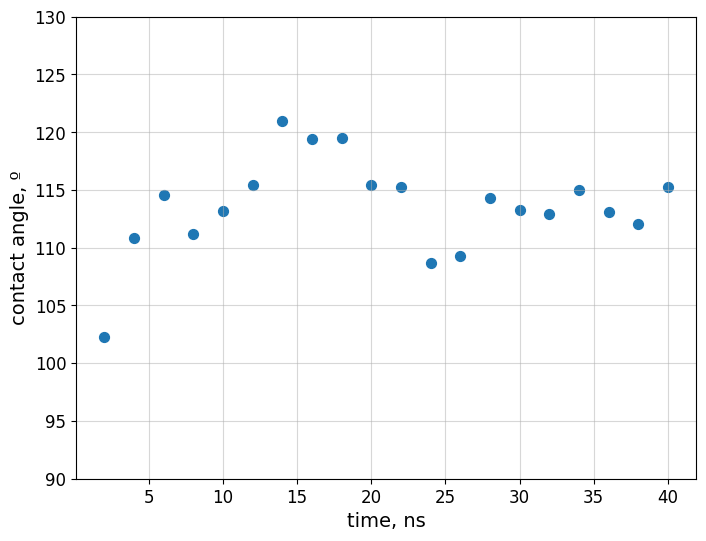

In [20]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5)

t = np.arange(2, 41, 2)
plt.scatter(t, angles_deg, s=50)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time, ns', fontsize=14)
plt.ylabel('contact angle, º', fontsize=14)
plt.ylim(90, 130)
plt.show()